In [1]:
import sys
sys.path.append('../')

import numpy as np
import torch

%matplotlib inline
import matplotlib.pyplot as plt

from modules.modules import VectorQuantizedVAE, GatedPixelCNN
from datasets import datasets

def norm_img(x):
    h = x.copy()
    h -= h.min()
    h /= h.max()
    return h


dataset = datasets.get_dataset('kylberg', '~/dataset/kylberg')

In [2]:
test_dataset = dataset['test']
num_channels = dataset['num_channels']

In [3]:
k = 256
hidden_size = 256

In [4]:
model = VectorQuantizedVAE(num_channels, hidden_size, k)

In [5]:
model.load_state_dict(torch.load('../models/kylberg_k256/best.pt'))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [6]:

hidden_prior = 64
num_layer = 15
n_classes = len(test_dataset._label_encoder)
pixelcnn_model = GatedPixelCNN(k, hidden_prior, num_layer, n_classes=n_classes)

Skipping initialization of  GatedMaskedConv2d
Skipping initialization of  GatedMaskedConv2d
Skipping initialization of  GatedMaskedConv2d
Skipping initialization of  GatedMaskedConv2d
Skipping initialization of  GatedMaskedConv2d
Skipping initialization of  GatedMaskedConv2d
Skipping initialization of  GatedMaskedConv2d
Skipping initialization of  GatedMaskedConv2d
Skipping initialization of  GatedMaskedConv2d
Skipping initialization of  GatedMaskedConv2d
Skipping initialization of  GatedMaskedConv2d
Skipping initialization of  GatedMaskedConv2d
Skipping initialization of  GatedMaskedConv2d
Skipping initialization of  GatedMaskedConv2d
Skipping initialization of  GatedMaskedConv2d


In [7]:
pixelcnn_model.load_state_dict(torch.load('../models/pixelcnn_kylberg_k256/best.pixelcnn.model'))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [8]:
model.eval()
model.cpu()
pixelcnn_model.eval()
pixelcnn_model.cpu()

GatedPixelCNN(
  (embedding): Embedding(256, 64)
  (layers): ModuleList(
    (0): GatedMaskedConv2d(
      (class_cond_embedding): Embedding(28, 128)
      (vert_stack): Conv2d(64, 128, kernel_size=(4, 7), stride=(1, 1), padding=(3, 3))
      (vert_to_horiz): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1))
      (horiz_stack): Conv2d(64, 128, kernel_size=(1, 4), stride=(1, 1), padding=(0, 3))
      (horiz_resid): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
      (gate): GatedActivation()
    )
    (1): GatedMaskedConv2d(
      (class_cond_embedding): Embedding(28, 128)
      (vert_stack): Conv2d(64, 128, kernel_size=(2, 3), stride=(1, 1), padding=(1, 1))
      (vert_to_horiz): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1))
      (horiz_stack): Conv2d(64, 128, kernel_size=(1, 2), stride=(1, 1), padding=(0, 1))
      (horiz_resid): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
      (gate): GatedActivation()
    )
    (2): GatedMaskedConv2d(
      (class_cond_embedding

In [9]:
np.random.seed(0)
index = np.random.permutation(len(test_dataset))[:10]
img = [test_dataset[i][0] for i in index]
img = torch.stack(img)

label = [test_dataset[i][1] for i in index]
label = torch.Tensor(label)
label =label.long()

In [10]:
pixelcnn_model.cuda()

GatedPixelCNN(
  (embedding): Embedding(256, 64)
  (layers): ModuleList(
    (0): GatedMaskedConv2d(
      (class_cond_embedding): Embedding(28, 128)
      (vert_stack): Conv2d(64, 128, kernel_size=(4, 7), stride=(1, 1), padding=(3, 3))
      (vert_to_horiz): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1))
      (horiz_stack): Conv2d(64, 128, kernel_size=(1, 4), stride=(1, 1), padding=(0, 3))
      (horiz_resid): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
      (gate): GatedActivation()
    )
    (1): GatedMaskedConv2d(
      (class_cond_embedding): Embedding(28, 128)
      (vert_stack): Conv2d(64, 128, kernel_size=(2, 3), stride=(1, 1), padding=(1, 1))
      (vert_to_horiz): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1))
      (horiz_stack): Conv2d(64, 128, kernel_size=(1, 2), stride=(1, 1), padding=(0, 1))
      (horiz_resid): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
      (gate): GatedActivation()
    )
    (2): GatedMaskedConv2d(
      (class_cond_embedding

In [11]:
latent = pixelcnn_model.generate(label.cuda(), shape=(16, 16), batch_size=10)

latent = latent.cpu()

out = model.decode(latent)

/home/genta/.pyenv/versions/pytorch/lib/python3.6/site-packages/torch/nn/functional.py:1374: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/genta/.pyenv/versions/pytorch/lib/python3.6/site-packages/torch/nn/functional.py:1386: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [12]:
out = out.cpu()

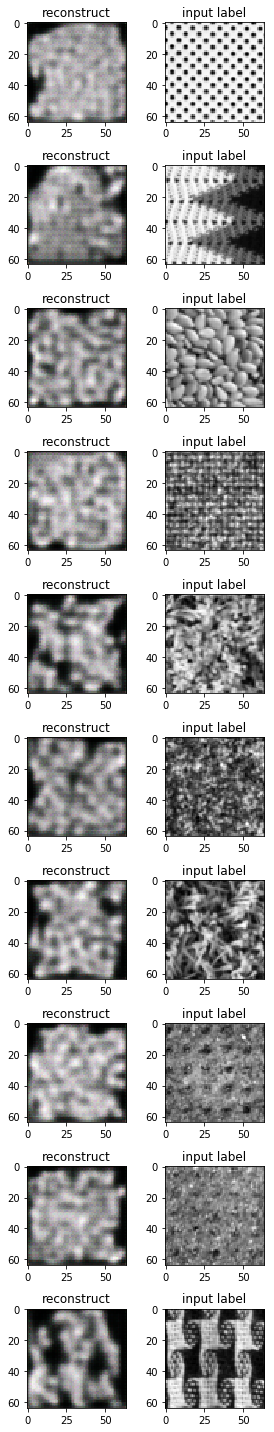

In [16]:
np_data = out.detach().numpy()
plt.figure(figsize=(4, len(np_data)*2))
for cnt, i in enumerate(np_data):
    tmp = np.transpose(norm_img(i), (1, 2, 0))
#     tmp = np.transpose(i, (1, 2, 0))
#     tmp = np.transpose(tmp, (1, 2, 0))
    plt.subplot(len(np_data), 2, 2*cnt+1)
    plt.title('reconstruct')
    plt.imshow(tmp)
    plt.subplot(len(np_data), 2, 2*cnt+2)
    tmp = np.transpose(norm_img(img[cnt].numpy()), (1, 2, 0))
    plt.title('input label')
    plt.imshow(tmp)
plt.tight_layout()
plt.savefig('kylberg.png')
plt.show()

In [24]:
latent8 = pixelcnn_model.generate(label.cuda(), shape=(32, 32), batch_size=10)

latent8 = latent8.cpu()

out = model.decode(latent8)

In [25]:
out = out.cpu()

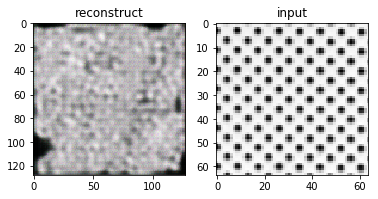

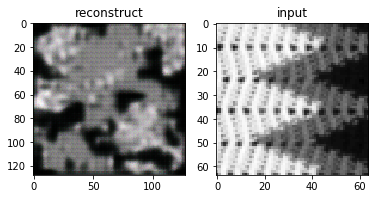

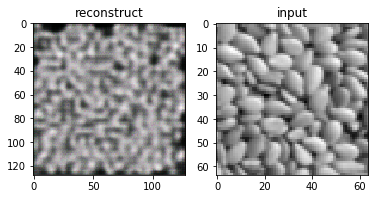

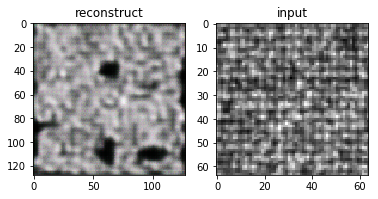

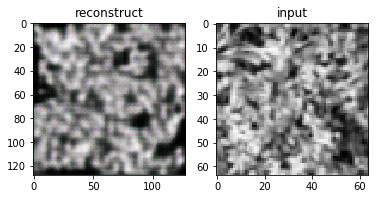

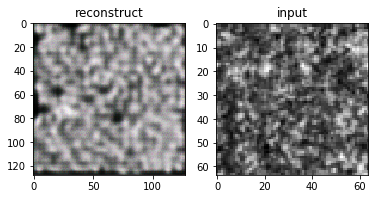

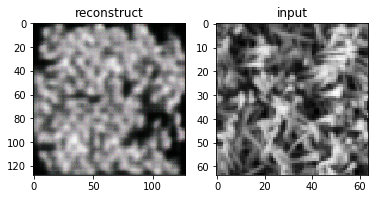

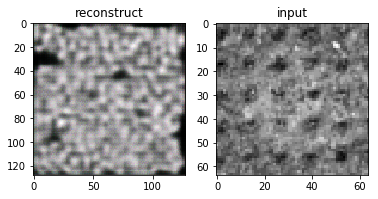

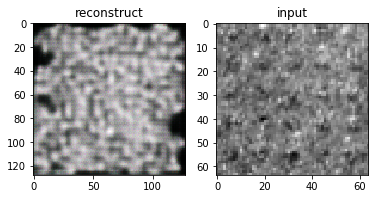

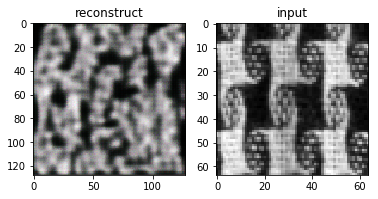

In [26]:
np_data = out.detach().numpy()
for cnt, i in enumerate(np_data):
    tmp = np.transpose(norm_img(i), (1, 2, 0))
    plt.subplot(1, 2, 1)
    plt.title('reconstruct')
    plt.imshow(tmp)
    plt.subplot(1, 2, 2)
    tmp = np.transpose(norm_img(img[cnt].numpy()), (1, 2, 0))
    plt.title('input')
    plt.imshow(tmp)
    plt.show()